In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mytools import Video, get_cuts

2023-12-01 15:42:57.899132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:42:57.936744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 15:42:57.936783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 15:42:57.936814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 15:42:57.943200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:42:57.943644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load model

In [2]:
model_path = 'models'
model_files = np.array(os.listdir(model_path))
model_files = np.sort(model_files[np.char.find(model_files, '.h5') != -1])
model_path = os.path.join(model_path, model_files[-1])
print(f'We a going to upload model {model_path}')

We a going to upload model models/2023-12-01-15-24.h5


In [3]:
model = tf.keras.models.load_model(model_path)
model.summary()

2023-12-01 15:42:59.701846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 15:42:59.723653: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 157, 87, 32)    6176      
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 78, 43, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 76, 41, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 38, 20, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 48640)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [4]:
input_size = tuple(model.input.shape[1:])
video_size = input_size[1], input_size[2]
print(f'Model input shape is {input_size}')
print(f'So video size should be {video_size}')

Model input shape is (6, 160, 90, 3)
So video size should be (160, 90)


# Analyzer

In [5]:
def predict_cuts(model, video: Video, fill=True, fill_value=0, fill_begin=None, fill_end=None):
    """
    Returns predicted cuts.
    
    Parameters:
    -----------
    model : keras model
    
    video : mytools.Video
    
    fill : bool
        Add values to the begin and end of result
    
    fill_value : int or bool
        Value, which will added to the begin and the end, if fill is True
        
    fill_begin : int
        Number of added values to begin
        
    fill_end : int
        Number of added values to end
    
    Returns:
    --------
    res : np.array
    """
    input_size = tuple(model.input.shape[1:])
    video_size = input_size[2], input_size[1]
    fragment_length = input_size[0]
    if (fill_begin is None) and (fill_end is None):
        fill_begin = fragment_length // 2
        fill_end = fragment_length - fill_begin
    elif fill_end is None:
        fill_end = fragment_length - fill_begin
    elif fill_begin is None:
        fill_begin = fragment_length - fill_end
    
    res = []
    
    pbar = tqdm(total=len(video) - fragment_length)
    # Make here loop of video fragments length 4 (fragment_length) and add predicted value every step
    for matrix in video.generate_matrices(matrix_length=fragment_length, new_size=video_size):
        X = matrix.reshape(np.append(1, matrix.shape))
        y = model(X)
        res.append(y)
        pbar.update()
    pbar.close()
    
    if fill:
        res = np.concatenate([np.ones(fill_begin)*fill_value, np.array(res)[:, 0, 0], np.ones(fill_end)*fill_value])
    return res

# Video 0

In [6]:
video_index = 0
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [7]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 107,  206,  221,  226,  237,  244,  249,  253,  256,  265,  273,
        295,  325,  329,  333,  338,  341,  365,  378,  384,  394,  404,
        419,  423,  432,  500,  580,  640,  665,  686,  711,  724,  762,
        775,  791,  806,  819,  841,  908,  958, 1083, 1151, 1186, 1233,
       1250, 1299, 1343, 1375, 1389, 1403, 1419, 1440, 1483, 1533, 1572,
       1596, 1634, 1657, 1750, 1918, 2005, 2100, 2190, 2249, 2303, 2329,
       2353, 2385, 2407, 2444, 2486, 2521, 2565, 2587, 2621, 2694, 2727,
       2748, 2763, 2792, 2816, 2828, 2846, 2862, 2878, 2889, 2901, 2921,
       2935, 2947, 2969, 2986, 2998, 3014, 3031, 3045, 3060, 3068, 3108,
       3185, 3239, 3284, 3324, 3368, 3415, 3451, 3503, 3615, 3679, 3712,
       3870, 3905, 3936, 3960, 3982, 4006, 4027, 4210, 4246, 4275, 4298,
       4326, 4363, 4400, 4433, 4472, 4511, 4592, 4608, 4648, 4674, 4700,
       4726, 4754, 4775, 4812, 4845, 4877, 4924, 4951, 4985, 5016, 5065,
       5129, 5156, 5216, 5253, 5310, 5367, 5502, 58

In [8]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [9]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5869 [00:00<?, ?it/s]

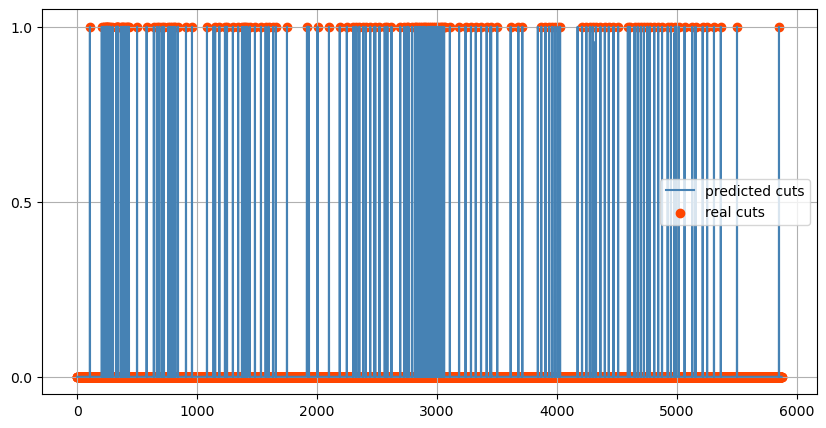

In [10]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [11]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[232:].head(20).transpose()

232    233    234    235    236   237    238    239    240  \
real cut       False  False  False  False  False  True  False  False  False   
predicted cut  False  False  False  False  False  True  False  False  False   

                 241    242    243   244    245    246    247    248   249  \
real cut       False  False  False  True  False  False  False  False  True   
predicted cut  False  False  False  True  False  False  False   True  True   

                 250    251  
real cut       False  False  
predicted cut  False  False

In [12]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5680             44
real cut                    1            150

In [13]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.75% wrong cuts predicted and 0.02% wrong noncuts.
But the real cuts portion is just 2.55%


predicted noncut  predicted cut
real noncut          0.966809       0.007489
real cut             0.000170       0.025532

/tmp/ipykernel_34158/1528520417.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


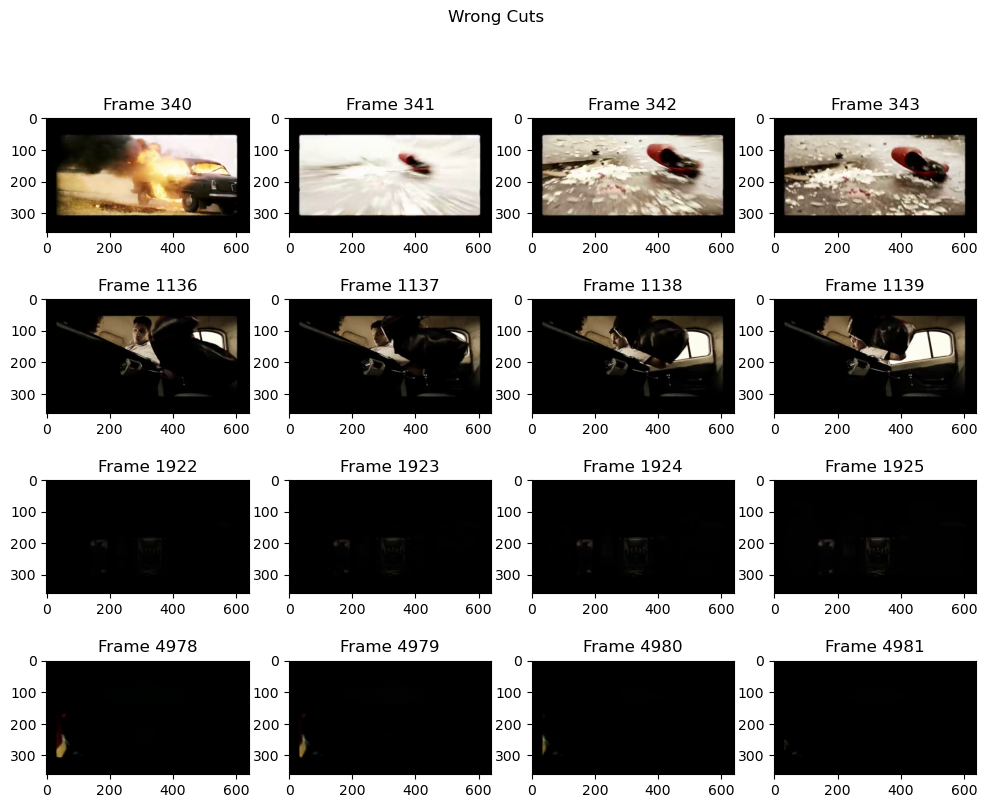

In [14]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

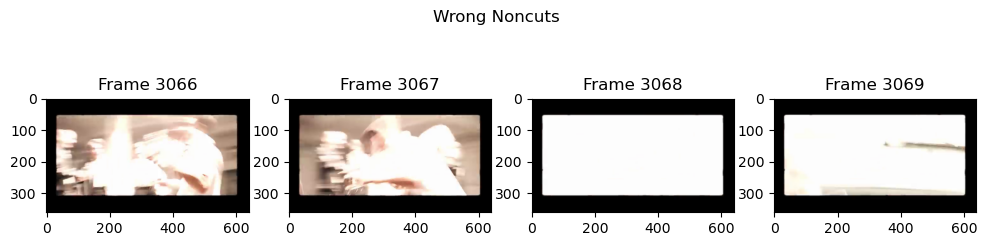

In [15]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [16]:
dfs_frames = []
dfs_square = []

In [17]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Video 1

In [18]:
video_index = 1
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [19]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 101,  140,  184,  202,  239,  290,  385,  402,  426,  447,  502,
        546,  607,  624,  637,  650,  670,  688,  703,  713,  738,  755,
        776,  789,  810,  851,  878,  921,  942,  960,  982,  998, 1009,
       1053, 1074, 1077, 1079, 1084, 1106, 1123, 1149, 1174, 1193, 1196,
       1199, 1201, 1208, 1213, 1250, 1253, 1259, 1276, 1293, 1295, 1302,
       1306, 1312, 1352, 1415, 1446, 1466, 1503, 1522, 1561, 1593, 1604,
       1617, 1686, 1741, 1765, 1801, 1810, 1820, 1845, 1877, 1905, 1927,
       1970, 2021, 2066, 2109, 2123, 2134, 2158, 2195, 2204, 2210, 2224,
       2248, 2273, 2295, 2316, 2329, 2349, 2374, 2384, 2400, 2407, 2412,
       2425, 2443, 2454, 2466, 2472, 2478, 2510, 2557, 2561, 2568, 2573,
       2577, 2601, 2613, 2623, 2717, 2772, 2795, 2829, 2847, 2857, 2871,
       2875, 2878, 2882, 2908, 2915, 2933, 2950, 2958, 2969, 2983, 2992,
       2998, 3006, 3013, 3015, 3016, 3017, 3018, 3019, 3021, 3022, 3027,
       3032, 3119, 3134, 3183, 3233, 3268, 3323, 33

In [20]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [21]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5744 [00:00<?, ?it/s]

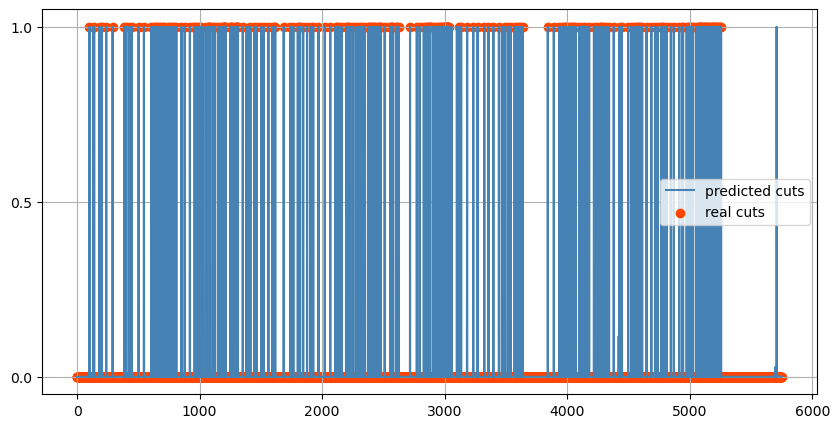

In [22]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [23]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [24]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5388            122
real cut                   17            223

In [25]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 2.12% wrong cuts predicted and 0.30% wrong noncuts.
But the real cuts portion is just 3.88%


predicted noncut  predicted cut
real noncut          0.937043       0.021217
real cut             0.002957       0.038783

/tmp/ipykernel_34158/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


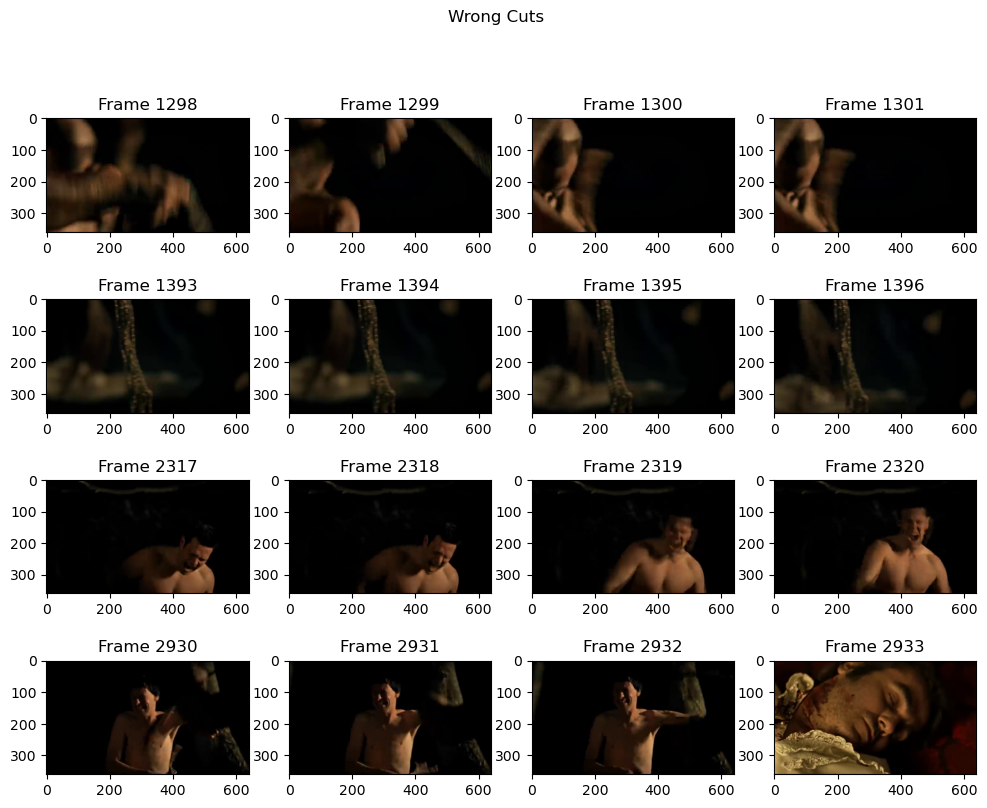

In [26]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_34158/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


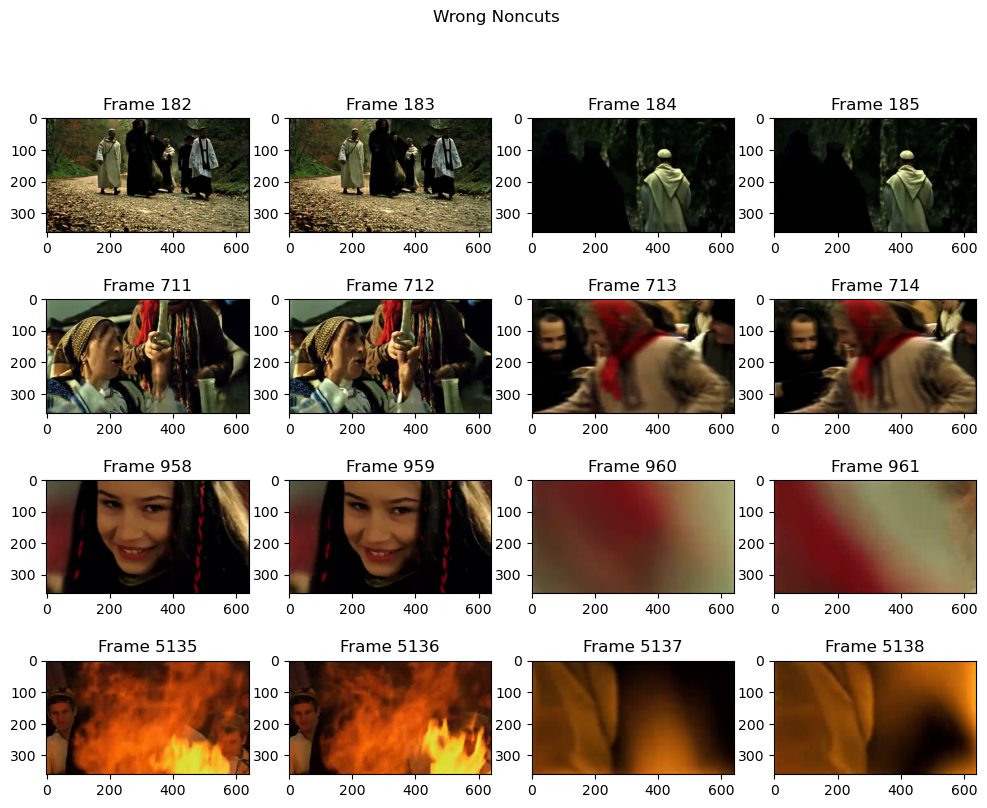

In [27]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

Wrong labaling: 941, 1192.

Changing FPS value in get_cuts have not resolved that.

In [28]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Video 2

In [29]:
video_index = 2
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [30]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  23,   65,   95,  103,  131,  141,  170,  180,  191,  208,  220,
        256,  282,  297,  315,  332,  348,  373,  404,  426,  470,  484,
        493,  512,  531,  548,  561,  586,  608,  666,  684,  710,  786,
        800,  814,  845,  864,  890,  925,  961,  992, 1007, 1076, 1098,
       1118, 1146, 1163, 1192, 1242, 1293, 1327, 1369, 1387, 1404, 1428,
       1456, 1484, 1497, 1519, 1546, 1570, 1601, 1625, 1635, 1640, 1646,
       1684, 1698, 1761, 1799, 1822, 1852, 1893, 1905, 1928, 1943, 1960,
       1992, 2012, 2049, 2084, 2102, 2332, 2393, 2409, 2558, 2581, 2597,
       2623, 2679, 2759, 2848, 2910, 2959, 3044, 3121, 3139, 3173, 3204,
       3238, 3264, 3295, 3353, 3405, 3457, 3483, 3522, 3596, 3609, 3622,
       3658, 3697, 3745, 3813, 3917, 4015, 4061, 4152, 4221, 4313, 4426,
       4468, 4522, 4590, 4698, 4731, 4797, 4839, 4869, 4933, 4989, 5020,
       5058, 5107, 5146, 5174, 5204, 5228, 5306, 5350, 5457, 5530, 5573,
       5608, 5620, 5643, 5660, 5676, 5704, 5735])

In [31]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [32]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/6055 [00:00<?, ?it/s]

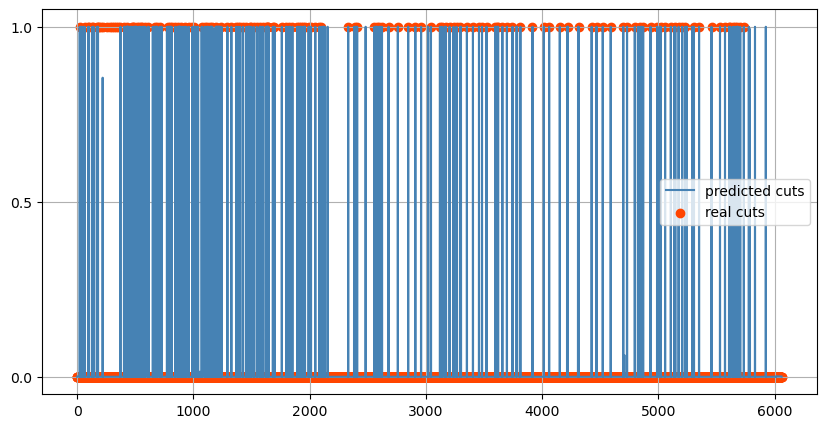

In [33]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [34]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False  False   True  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [35]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5722            189
real cut                   10            140

In [36]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 3.12% wrong cuts predicted and 0.16% wrong noncuts.
But the real cuts portion is just 2.31%


predicted noncut  predicted cut
real noncut          0.944069       0.031183
real cut             0.001650       0.023098

/tmp/ipykernel_34158/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


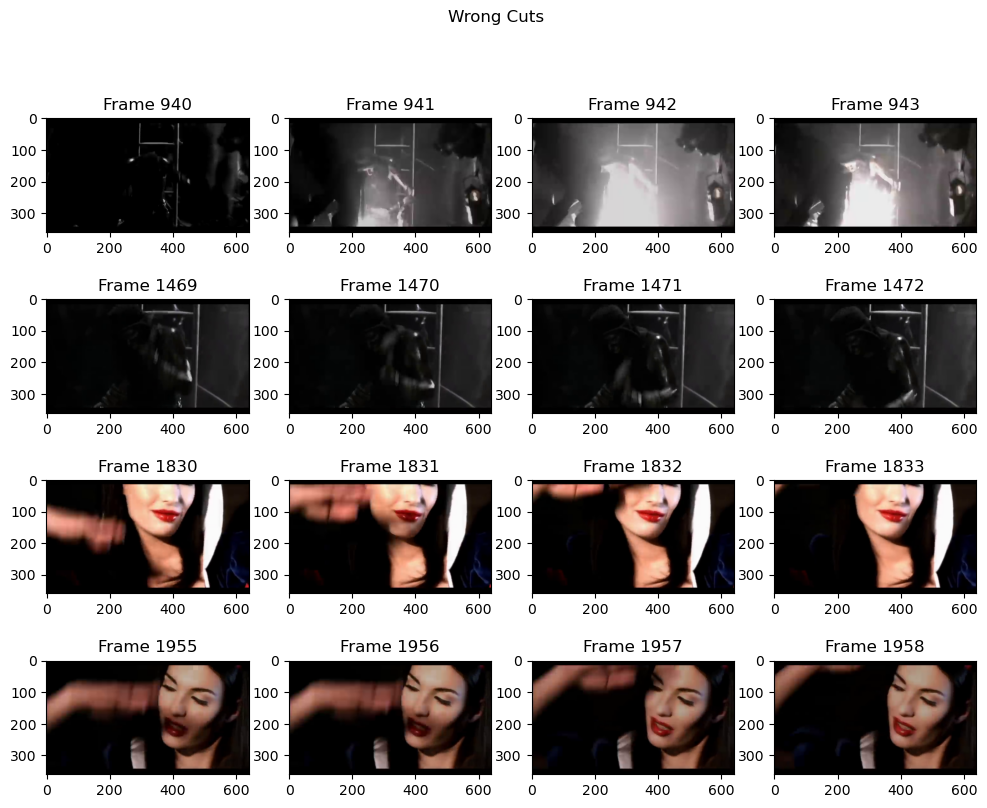

In [37]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_34158/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


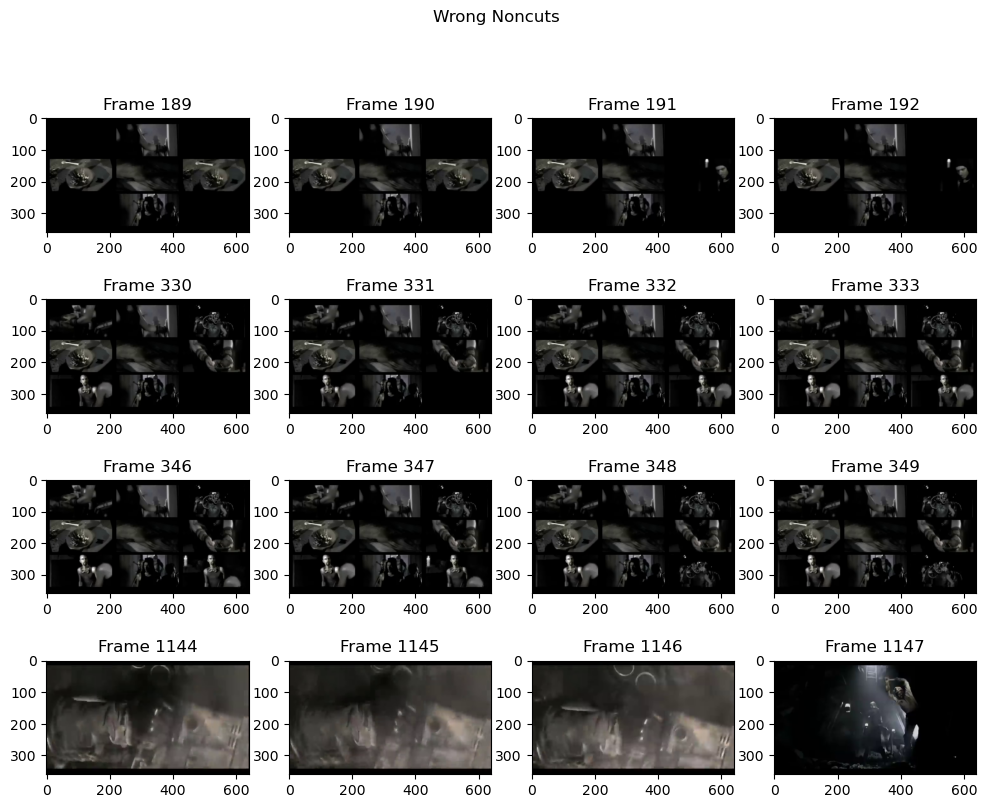

In [38]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

Wrong labaling for the frames 547, 1075

Many cuts on 9 little frames are realy specific.

In [39]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Video 3

In [40]:
video_index = 3
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [41]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 160,  203,  320,  479,  639,  757,  970, 1049, 1119, 1300, 1599,
       1760, 1919, 1999, 2245, 2344, 2401, 2560, 2719, 2880, 3040, 3359])

In [42]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [43]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/3955 [00:00<?, ?it/s]

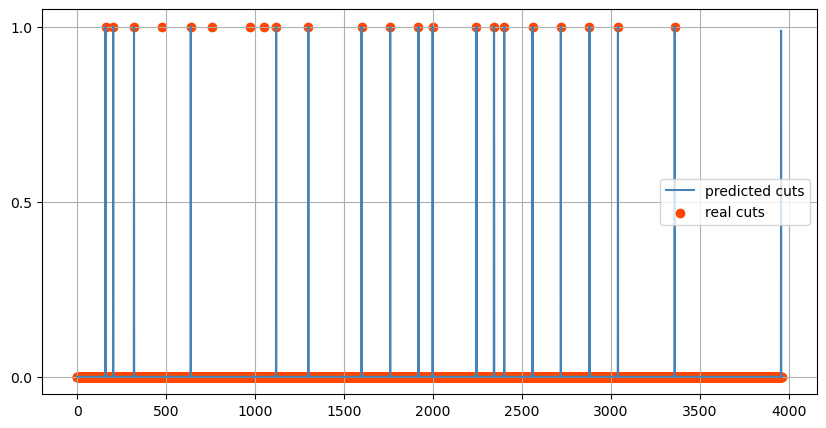

In [44]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [45]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [46]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              3936              3
real cut                    4             18

In [47]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.08% wrong cuts predicted and 0.10% wrong noncuts.
But the real cuts portion is just 0.45%


predicted noncut  predicted cut
real noncut          0.993688       0.000757
real cut             0.001010       0.004544

/tmp/ipykernel_34158/2537299419.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


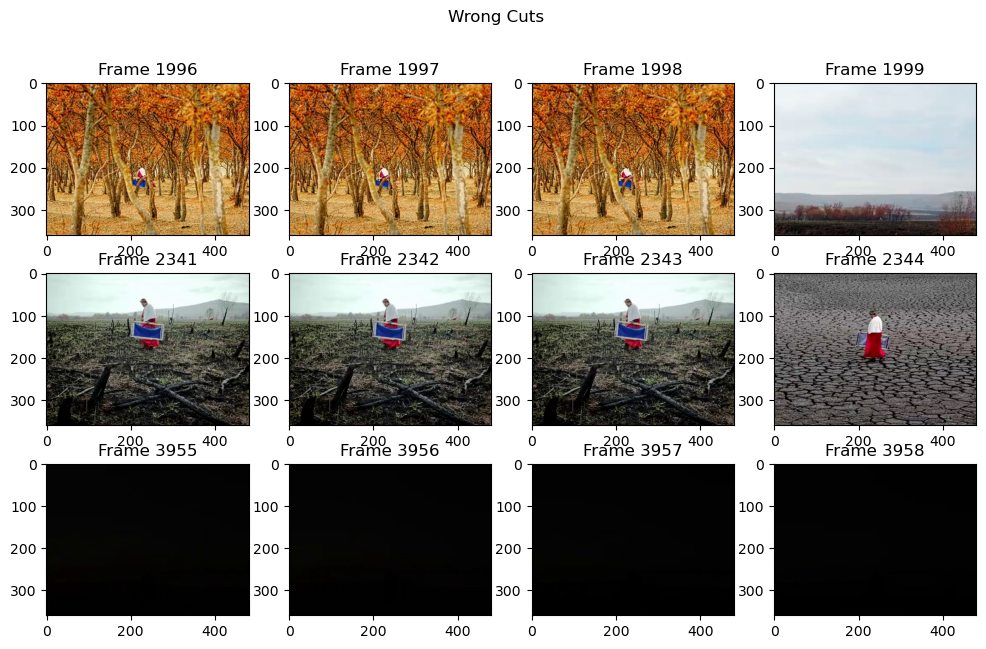

In [48]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_34158/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


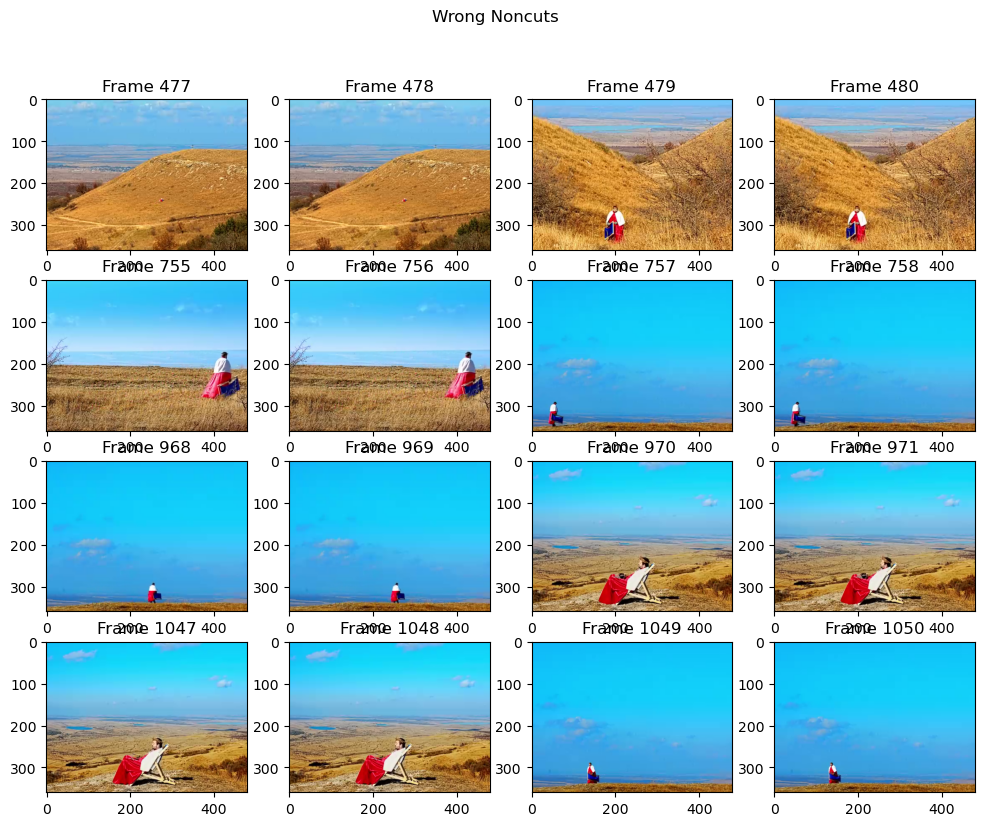

In [49]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [50]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Video 4

In [51]:
video_index = 4
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [52]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  25,  162,  232,  260,  284,  312,  336,  366,  389,  415,  439,
        471,  492,  520,  539,  566,  610,  656,  693,  745,  770,  792,
        819,  837,  860,  881,  910,  938,  974,  995, 1020, 1043, 1065,
       1073, 1101, 1123, 1145, 1167, 1177, 1206, 1227, 1247, 1266, 1284,
       1307, 1323, 1344, 1360, 1379, 1405, 1420, 1439, 1460, 1489, 1517,
       1546, 1562, 1592, 1609, 1641, 1671, 1698, 1735, 1759, 1788, 1805,
       1830, 1853, 1866, 1879, 1889, 1901, 1918, 1932, 1960, 1972, 1990,
       2003, 2030, 2042, 2055, 2064, 2071, 2080, 2092, 2102, 2114, 2142,
       2169, 2193, 2204, 2222, 2243, 2255, 2274, 2280, 2295, 2321, 2351,
       2369, 2381, 2396, 2420, 2437, 2455, 2469, 2478, 2510, 2536, 2563,
       2583, 2604, 2624, 2647, 2664, 2680, 2689, 2706, 2721, 2734, 2741,
       2758, 2771, 2810, 2843, 2872, 3013, 3160, 3196, 3221, 3249, 3282,
       3319, 3345, 3371, 3393, 3426, 3473, 3502, 3553, 3580, 3650, 3689,
       3729, 3758, 3796, 3810, 3848, 3863, 3900, 39

In [53]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [54]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5243 [00:00<?, ?it/s]

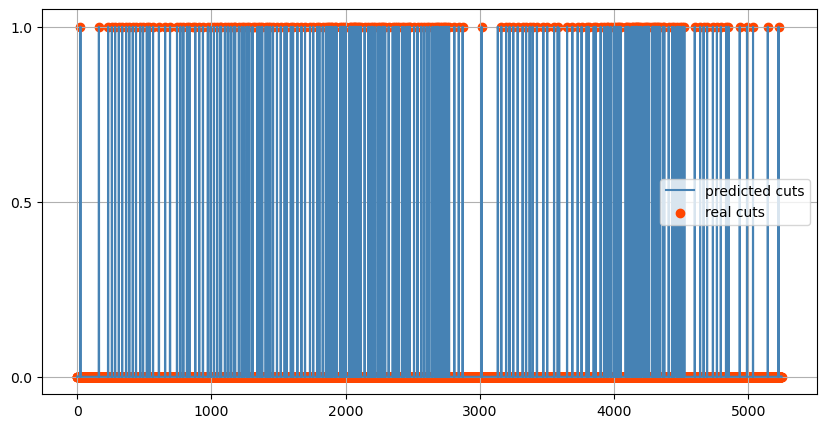

In [55]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [56]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470   471    472    473  \
real cut       False  False  False  False  False  False  True  False  False   
predicted cut  False  False  False  False  False   True  True  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [57]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              4979             67
real cut                    8            195

In [58]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 1.28% wrong cuts predicted and 0.15% wrong noncuts.
But the real cuts portion is just 3.71%


predicted noncut  predicted cut
real noncut          0.948562       0.012764
real cut             0.001524       0.037150

/tmp/ipykernel_34158/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


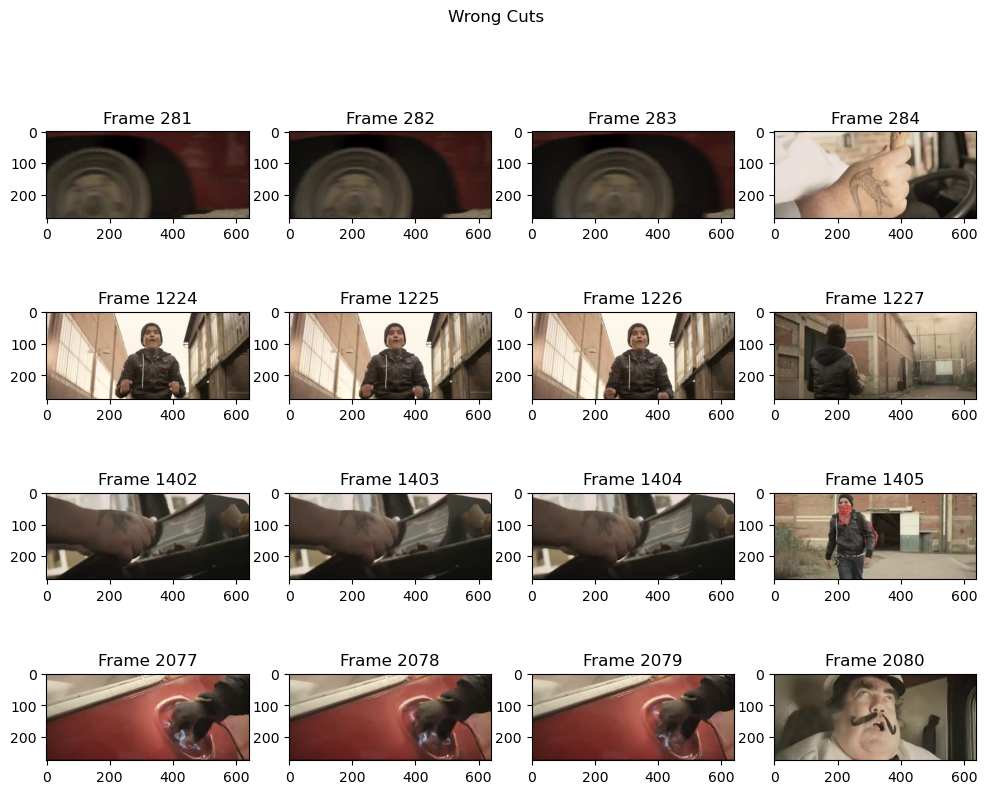

In [59]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

There are many stable segments! Why?

/tmp/ipykernel_34158/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


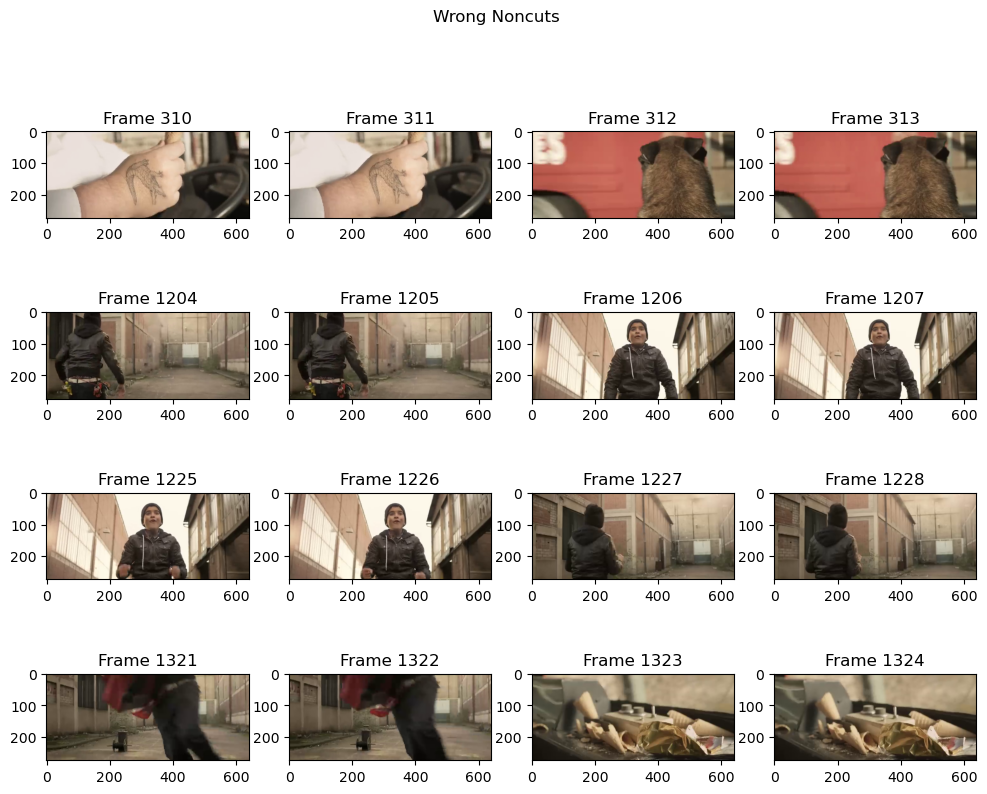

In [60]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [61]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Video 5

In [62]:
video_index = 5
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [63]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  46,   99,  145,  177,  269,  303,  347,  381,  427,  464,  488,
        531,  561,  609,  640,  664,  687,  715,  759,  790,  837,  914,
        988, 1061, 1098, 1142, 1175, 1367, 1493, 1516, 1670, 1747, 1800,
       1826, 1895, 1973, 2045, 2095, 2130, 2205, 2244, 2282, 2354, 2392,
       2436, 2634, 2658, 2708, 2733, 2812, 2880, 2963, 3065, 3112, 3186,
       3265, 3342, 3493, 3521, 3571, 3617, 3646, 3668, 3689, 3718, 3760,
       3800, 3838, 3873, 3898, 3925, 3952, 3995, 4025, 4076, 4103, 4130,
       4160, 4198, 4225, 4253, 4329, 4387, 4480, 4521, 4554, 4610, 4658,
       4700, 4749, 4787, 4856, 4972])

In [64]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [65]:
cuts_predicted = predict_cuts(model, video)

  0%|          | 0/5000 [00:00<?, ?it/s]

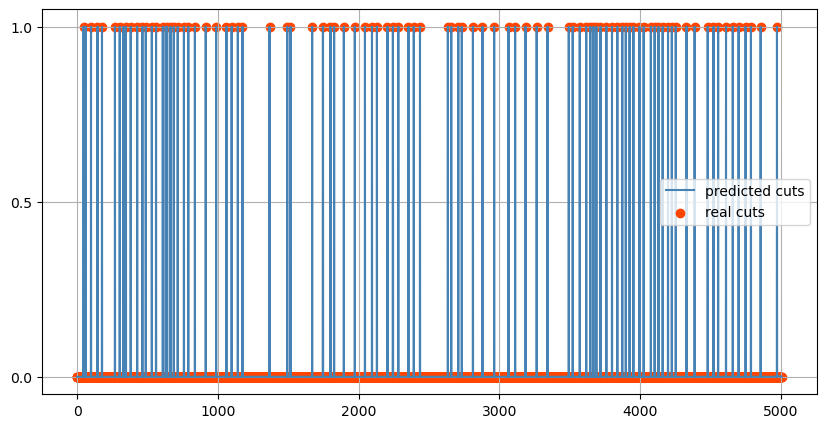

In [66]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [67]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463   464  \
real cut       False  False  False  False  False  False  False  False  True   
predicted cut  False  False  False  False  False  False  False  False  True   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [68]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              4906              7
real cut                    0             93

In [69]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.14% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 1.86%


predicted noncut  predicted cut
real noncut          0.980024       0.001398
real cut             0.000000       0.018578

/tmp/ipykernel_34158/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


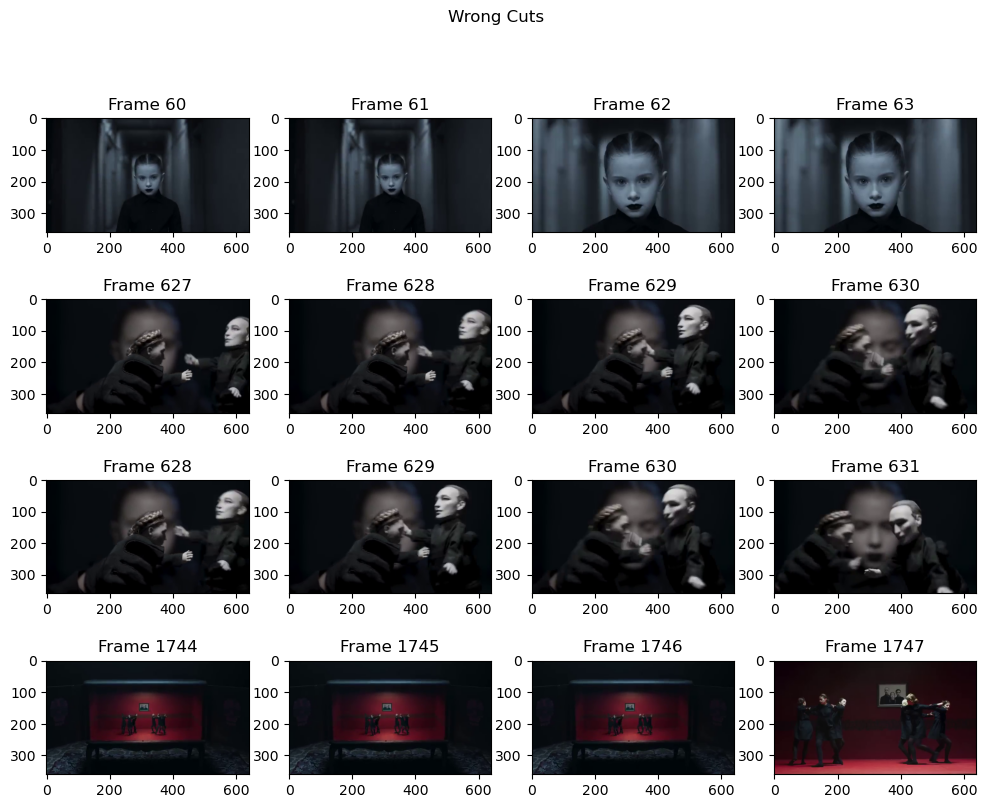

In [70]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [71]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


In [72]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Conclusion

In [79]:
learning = [0, 1, 4, 5]
nonlearning = [2, 3]
rammstein = [0, 1, 2]
nonrammstein = [3, 4, 5]
agressive = [0, 1, 2, 4]
peacefull = [3, 5]

In [95]:
df_square_total = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in range(6):
    df_square_total = df_square_total + dfs_square[i]
df_square_total

predicted noncut  predicted cut
real noncut             30611            432
real cut                   40            819

In [96]:
print('Total accuracy: {0:.4f}'.format(((df_square_total / df_square_total.values.sum()).values*np.eye(2)).sum()))    
print('Total result:')
df_square_total / df_square_total.values.sum()

Total accuracy: 0.9852
Total result:


predicted noncut  predicted cut
real noncut          0.959532       0.013541
real cut             0.001254       0.025672

In [74]:
df_square_learning = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in learning:
    df_square_learning = df_square_learning + dfs_square[i]
print('Learning result:')
df_square_learning / df_square_learning.values.sum()

Learning result:


predicted noncut  predicted cut
real noncut          0.957633       0.010969
real cut             0.001188       0.030210

In [75]:
df_square_nonlearning = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in nonlearning:
    df_square_nonlearning = df_square_nonlearning + dfs_square[i]
print('Nonlearning result:')
df_square_nonlearning / df_square_nonlearning.values.sum()

Nonlearning result:


predicted noncut  predicted cut
real noncut          0.963680       0.019158
real cut             0.001397       0.015765

In [76]:
df_square_rammstein = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in rammstein:
    df_square_rammstein = df_square_rammstein + dfs_square[i]
print('Rammstein result:')
df_square_rammstein / df_square_rammstein.values.sum()

Rammstein result:


predicted noncut  predicted cut
real noncut          0.949338       0.020072
real cut             0.001583       0.029006

In [80]:
df_square_nonrammstein = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in nonrammstein:
    df_square_nonrammstein = df_square_nonrammstein + dfs_square[i]
print('Non Rammstein result:')
df_square_nonrammstein / df_square_nonrammstein.values.sum()

Non Rammstein result:


predicted noncut  predicted cut
real noncut          0.972214       0.005416
real cut             0.000844       0.021525

In [77]:
df_square_agressive = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in agressive:
    df_square_agressive = df_square_agressive + dfs_square[i]
print('Agressive result:')
df_square_agressive / df_square_agressive.values.sum()

Agressive result:


predicted noncut  predicted cut
real noncut          0.949161        0.01840
real cut             0.001570        0.03087

In [78]:
df_square_peacefull = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
for i in peacefull:
    df_square_peacefull = df_square_peacefull + dfs_square[i]
print('Peacefull result:')
df_square_peacefull / df_square_peacefull.values.sum()

Peacefull result:


predicted noncut  predicted cut
real noncut          0.986060       0.001115
real cut             0.000446       0.012379

There are many __wrong cut__ values got by analysis videos `videos/1.mp4` and `videos/2.mp4`]. These clips contains many actions, like fires, explosions, flashs or just jerks. 